# Spektrální bisekce grafu

## Úvodní příklad

Uvažujeme řídkou matici o rozměrech $6 \times 6$ se symetrickou strukturou nenulových prvků, viz níže. Úkolem je rozdělit řádky (nebo sloupce) této matice tak, aby na každém z procesorů byl stejný počet řádků (*load balancing*) a při výpočtu součinu $y = Ax$ bylo provedeno co nejméně komunikací (*minimal cut*).

In [28]:
using LinearAlgebra
using SparseArrays

In [29]:
A = 2 * sparse(1.0I,6,6)

A[1, [2,3]] = [1,1]
A[2, [3,4]] = [1,1]
A[3, 6]     = 1
A[4, [5,6]] = [1,1]
A[5, 6]     = 1

A = A + transpose(A)
Array(A)

6×6 Array{Float64,2}:
 4.0  1.0  1.0  0.0  0.0  0.0
 1.0  4.0  1.0  1.0  0.0  0.0
 1.0  1.0  4.0  0.0  0.0  1.0
 0.0  1.0  0.0  4.0  1.0  1.0
 0.0  0.0  0.0  1.0  4.0  1.0
 0.0  0.0  1.0  1.0  1.0  4.0

In [30]:
using PyPlot;

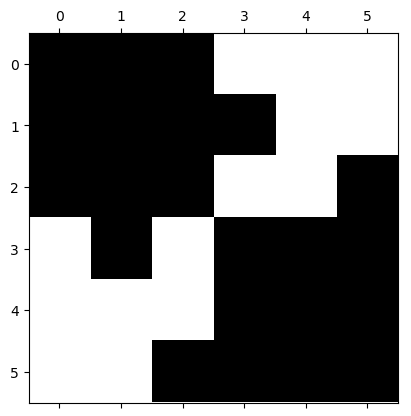

In [31]:
spy(Array(A));

### Graf popisující strukturu matice

Strukturu nenulových prvků matice $A$ popíšeme pomocí grafu
$$
    \mathcal G = \{\mathcal V, \mathcal E\},
$$
kde 
 - $\mathcal V$ je množina vrcholů odpovídající řádkům matice, tj. $|\mathcal V|=n=6$ a 
 - $\mathcal E = \{ \{i,j\} : a_{ij} \ne 0 \land i\ne j \} $ je množina hran odpovídající nenulovým prvkům matice $A$.
 
Pozn. uvažujeme matice se symetrickou strukturou, tj. $\{i,j\} = \{j,i\}$.

V grafu zavedeme *libovolnou* orientaci (např. tak, že $i<j$). Pro tento **orientovaný** graf definujeme incidenční matici jako
$$
    E_{kj} = \left\{
    \begin{array}{ll}
        -1 & \mbox{pokud hrana $k$ vychází z vrcholu $j$,} \\
        1 & \mbox{pokud hrana $k$ vchází do vrcholu $j$,} \\
        0 & \mbox{jinak.} 
    \end{array}
    \right.
$$

In [5]:
function incidence_matrix(A)
    n = size(A,1)
    m = div((nnz(A) - n), 2)
    E = spzeros(m,n)
    rows = rowvals(A)
    k = 1
    for i = 1:n
        for  l in nzrange(A,i)
            j = rows[l]
            if i < j
                E[k,i] = -1.
                E[k,j] =  1.
                k+=1
            end
        end
    end
    return E
end

incidence_matrix (generic function with 1 method)

In [6]:
E = incidence_matrix(A)
Array(E)

8×6 Array{Float64,2}:
 -1.0   1.0   0.0   0.0   0.0  0.0
 -1.0   0.0   1.0   0.0   0.0  0.0
  0.0  -1.0   1.0   0.0   0.0  0.0
  0.0  -1.0   0.0   1.0   0.0  0.0
  0.0   0.0  -1.0   0.0   0.0  1.0
  0.0   0.0   0.0  -1.0   1.0  0.0
  0.0   0.0   0.0  -1.0   0.0  1.0
  0.0   0.0   0.0   0.0  -1.0  1.0

Rozdělení vrcholů grafu na procesory $\mathcal V = \mathcal V_1 \cup \mathcal V_2$ ($\mathcal V_1 \cap \mathcal V_2 = \emptyset$) pak můžeme popsat pomocí vektoru $c \in \{-1,1\}^n$ takto:
$$
  c_i = \left\{
  \begin{array}{ll}
    -1 & \mbox{pokud } i \in \mathcal V_1, \\
    1 & \mbox{pokud } i \in \mathcal V_2.
  \end{array}
  \right.
$$

In [7]:
c = [1, -1, 1, -1, 1, -1]
c'

1×6 Adjoint{Int64,Array{Int64,1}}:
 1  -1  1  -1  1  -1

Součin $E c$ pak je
$$
    (Ec)_k = \left\{
    \begin{array}{ll}
      0 & \mbox{pokud hrana $k$ začíná i končí ve stejné části grafu,} \\
      \pm 2 & \mbox{pokud hrana začíná ve $\mathcal V_1$ a končí $\mathcal V_2$ nebo naopak.} 
    \end{array}
    \right.
$$

In [8]:
(E*c)'

1×8 Adjoint{Float64,Array{Float64,1}}:
 -2.0  0.0  2.0  0.0  -2.0  2.0  0.0  -2.0

Mohutnost řezu (počet hran spojující $\mathcal V_1$ s $\mathcal V_2$, tj. počet nutných komunikací při výpočtu součinu $y=Ax$) je potom $||Ec||^2/4$.

In [9]:
dot(E*c,E*c)/4

5.0

### Optimální řez grafu

Úlohu nalézt optimální řez grafu (se sudým počtem vrcholů) tedy můžeme formulovat takto: nalezněte vektor $c \in \{-1,1\}^n$ takový, že 
- $\sum_{i=1}^n c_i = (c, \vec{1}) = 0$ (load balancing)
- $c$ minimalizuje $||Ec||_2$
navíc z definice $c$ je vidět, že $||c||^2 = n$.

Tato úloha je však velmi obtížně řešitelná, proto přejdeme k přibližnému řešení v oboru reálných čísel.

## Spektrální bisekce grafu v oboru reálných čísel
Budeme uvažovat vektor $c \in \mathbb R^n$. Potom úlohu přeformulujeme takto: nalezněte reálný vektor $c\in \mathbb R^n$ takový, že
- $||c||=1$
- $(c,\vec{1}) = 0$
- $c$ minimalizuje $||Ec||^2 = (Ec,Ec)$.

Minimalizovaný výraz přepíšeme jako $||Ec||^2 = (Ec,Ec) = (E^TEc,c) = (Lc,c)$, kde $L=E^TE$

Matice $L$ se nazývá **Laplaceova matice** grafu a její prvky jsou
$$
    L_{ij} = \left\{
        \begin{array}{ll}
            |v_i| & \mbox{pro } i=j, \\
            -1 & \mbox{pro } a_{ij}\ne 0 \land i\ne j, \\
            0 & \mbox{jinak}
        \end{array}
    \right.
$$

In [10]:
L = transpose(E) * E
Array(L)

6×6 Array{Float64,2}:
  2.0  -1.0  -1.0   0.0   0.0   0.0
 -1.0   3.0  -1.0  -1.0   0.0   0.0
 -1.0  -1.0   3.0   0.0   0.0  -1.0
  0.0  -1.0   0.0   3.0  -1.0  -1.0
  0.0   0.0   0.0  -1.0   2.0  -1.0
  0.0   0.0  -1.0  -1.0  -1.0   3.0

Matice $L$ je symetrická pozitivně semidefinitní matice. Lze jí tedy diagonalizovat nad $\mathbb R$ a z jejích vlastních vektorů lze sestavit ortonormální bázi. Seřaďme vlastní čísla dle velikosti $0=\lambda_1 \le \lambda_2 \le ... \le \lambda_n$. Nechť $q_k$ je $k$-tý bázový vektor příslušející vlastnímu číslu $\lambda_k$ a $\gamma_k$ je $k$-tá souřadnice $c$ v této bázi (tj. $c=\sum \gamma_k q_k$), potom
$$
  1 = ||c||^2 = (c,c) = \sum_{k=1}^{n}{\gamma_k}^2,
$$
$$
    Lc = \sum \gamma_k L q_k = \sum \lambda_k \gamma_k q_k,
$$
a
$$
    (Lc,c) = \sum \lambda_k \gamma_k^2. 
$$

Dále platí $L \vec{1} = 0$ a tedy $\vec{1}$ je vlastní vektor odpovídající vlastnímu číslu $\lambda_1=0$. Minimalizaci $(Lc,c)$ tedy budeme provádět na ortogonálním doplňku $\vec{1}$, tj. na $span\{q_2,q_3,...,q_n\}$.

Je-li $\lambda_2$ jednonásobné, je $(Lc,c)$ řešením vektor $q_2$. 

In [11]:
eig=eigen(Array(L))
lambda = eig.values

6-element Array{Float64,1}:
 4.440892098500626e-15
 1.0000000000000036   
 3.000000000000001    
 3.0000000000000018   
 4.000000000000001    
 5.0                  

In [12]:
v2 = eig.vectors[:,2]

6-element Array{Float64,1}:
 -0.577350269189626  
 -0.2886751345948134 
 -0.2886751345948133 
  0.28867513459481275
  0.5773502691896253 
  0.2886751345948126 

Vrcholy rozdělíme podle znamének prvků $q_2$

In [13]:
c=[-1,-1,-1,1,1,1]
dot(E*c,E*c)/4

2.0

## Příklad 2 - matice s lichým počtem řádků 

In [14]:
B = 2 * sparse(1.0I,7,7)

B[1, 2] = 1; B[1, 3] = 1;
B[2, 3] = 1; B[2, 4] = 1;
B[3, 6] = 1;
B[4, 5] = 1; B[4, 6] = 1;
B[5, 6] = 1; B[5, 7] = 1;
B[6, 7] = 1
B = B + transpose(B)
Array(B)

7×7 Array{Float64,2}:
 4.0  1.0  1.0  0.0  0.0  0.0  0.0
 1.0  4.0  1.0  1.0  0.0  0.0  0.0
 1.0  1.0  4.0  0.0  0.0  1.0  0.0
 0.0  1.0  0.0  4.0  1.0  1.0  0.0
 0.0  0.0  0.0  1.0  4.0  1.0  1.0
 0.0  0.0  1.0  1.0  1.0  4.0  1.0
 0.0  0.0  0.0  0.0  1.0  1.0  4.0

In [15]:
EB = incidence_matrix(B);
LB = transpose(EB)*EB
eigb = eigen(Array(LB))
eigb.values'

1×7 Adjoint{Float64,Array{Float64,1}}:
 6.21725e-15  0.814349  2.32801  3.31391  3.59809  4.45753  5.48812

In [16]:
eigb.vectors[:,2]'

1×7 Adjoint{Float64,Array{Float64,1}}:
 -0.560099  -0.347898  -0.316183  0.115898  0.38428  0.216931  0.507072

## Příklad 3 - dělení na 3 procesory

Matici $A$ ($n=6$) nejprve rozdělíme v poměru 1:2 na dva procesory, pak vetší díl rozdělíme opět na 2 procesory.

Původní matici modifikujeme tak, že přidáme řádky a nenulové prvky tak, aby nově přidané řádky tvořily s posledním vrcholem původního grafu kliku.

In [17]:
A1 = sparse(1.0*I, 8,8)
#A = 2 * sparse(1.0*I, 6,6)

A1[1, 2] = 1; A1[1 ,3] = 1
A1[2, 3] = 1; A1[2 ,4] = 1
A1[3, 6] = 1
A1[4, 5] = 1; A1[4,6] = 1
A1[5, 6]     = 1

# Dodatečné prvky
A1[7,8] = 1

# Napojení na zbytek matice
A1[6,7] = 1; A1[6,8] = 1

A1 = A1 + transpose(A1)
Array(A1)

8×8 Array{Float64,2}:
 2.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0
 1.0  2.0  1.0  1.0  0.0  0.0  0.0  0.0
 1.0  1.0  2.0  0.0  0.0  1.0  0.0  0.0
 0.0  1.0  0.0  2.0  1.0  1.0  0.0  0.0
 0.0  0.0  0.0  1.0  2.0  1.0  0.0  0.0
 0.0  0.0  1.0  1.0  1.0  2.0  1.0  1.0
 0.0  0.0  0.0  0.0  0.0  1.0  2.0  1.0
 0.0  0.0  0.0  0.0  0.0  1.0  1.0  2.0

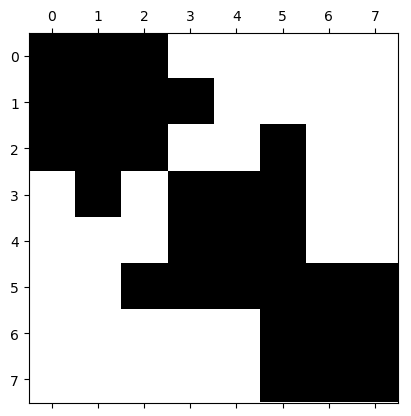

PyObject <matplotlib.image.AxesImage object at 0x7fd018696978>

In [18]:
spy(Array(A1))

In [19]:
E1 = incidence_matrix(A1);
L1 = transpose(E1)*E1
eig1 = eigen(Array(L1))
eig1.values'

1×8 Adjoint{Float64,Array{Float64,1}}:
 1.72492e-16  0.666432  1.27766  3.0  3.0  3.45155  4.35771  6.24665

In [20]:
eig1.vectors[:,2]

8-element Array{Float64,1}:
 -0.5041749916011007  
 -0.36850098401530174 
 -0.3038507461506857  
 -0.051896435925743514
  0.08377757166005582 
  0.1636195403896597  
  0.4905130228215556  
  0.49051302282155734 

## Nalezení vlastního vektoru $v_2$

Pro matici $L$ platí $\rho_L \le 2 \max_i L_{ii}$ (viz Geršgorinovo lemma)

In [21]:
maximum(eigvals(Array(L1)))

6.246645602915109

In [22]:
ρ =  2*maximum(diag(L1))

10.0

In [23]:
n = size(L1)[1]
B = ρ*sparse(1.0I,n,n) - L1
eigvals(Array(B))

8-element Array{Float64,1}:
  3.7533543970848933
  5.642285315132974 
  6.5484493182965124
  6.999999999999998 
  7.0               
  8.722342781125452 
  9.333568188360175 
 10.000000000000002 

In [24]:
C = B - ones(n,n)/n*ρ;
eigvals(C)

8-element Array{Float64,1}:
 -7.008367546241026e-16
  3.75335439708489     
  5.642285315132974    
  6.548449318296517    
  6.999999999999998    
  7.000000000000002    
  8.722342781125446    
  9.333568188360177    

In [25]:
v2 = rand(n)

8-element Array{Float64,1}:
 0.6545929041407128
 0.8944332252221858
 0.3980446395857675
 0.9233312887856762
 0.8804257705313983
 0.5414206655237457
 0.307506920301007 
 0.6677145925150083

In [26]:
for iter = 1:100
    v2 = B * v2 - ρ * ones(n,1)/n * sum(v2)
    v2 /= norm(v2)
end
v2

8×1 Array{Float64,2}:
  0.5033618200989188  
  0.368352530750492   
  0.30341092677361875 
  0.052893093224346675
 -0.08211619612456181 
 -0.1634159681581485  
 -0.49124310328263976 
 -0.491243103282026   

In [27]:
eigen(Array(L1)).vectors

8×8 Array{Float64,2}:
 -0.353553  -0.504175   -0.338876   …   0.450613   -0.227231   -0.0358441
 -0.353553  -0.368501   -0.0615343      0.138152    0.660569   -0.173157 
 -0.353553  -0.303851   -0.18325       -0.79224    -0.124824    0.325374 
 -0.353553  -0.0518964   0.416143       0.279244   -0.544809    0.272649 
 -0.353553   0.0837776   0.693484      -0.0332164   0.34299     0.135336 
 -0.353553   0.16362     0.0847905  …  -0.231029   -0.263863   -0.847373 
 -0.353553   0.490513   -0.305379       0.0942379   0.0785841   0.161508 
 -0.353553   0.490513   -0.305379       0.0942379   0.0785841   0.161508 